## NCAA March Madness

### Pomeroy Ratings and First Round Upset Picks

This notebook continues our examination of strategies for picking first round March Madness upsets. In this notebook, we will look at Ken Pomeroy's [KenPom college basketball ratings](https://kenpom.com/) and see how they can help us predict wins and losses.

We're going to merge the KenPom data with the Washington Post NCAA game history that we [analyzed previously](http://practicallypredictable.com/2018/03/07/march-madness-first-round-upsets/). By combining these data sets, we'll see whether the KenPom data would have helped predict upsets in previous NCAA tournaments.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_rows = 100

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', palette='colorblind')

In [3]:
import math
import warnings

In [4]:
from pathlib import Path

In [5]:
PROJECT_DIR = Path.cwd().parent
SCRAPED_DIR = PROJECT_DIR / 'data' / 'scraped'
PREPARED_DIR = PROJECT_DIR / 'data' / 'prepared'

### Loading the KenPom Data

First let's read in the previously scraped KenPom data.

See [this notebook](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/basketball/ncaa/notebooks/ncaa-scrape-kenpom.ipynb) to see how to scrape historical KenPom ratings.  

In [6]:
def read_kenpom_csv(filepath):
    """Read scraped KenPom CSV file."""
    filename = 'kenpom-historical.csv'
    csvfile = filepath.joinpath(filename)
    df = pd.read_csv(csvfile).dropna()
    return df

One challenge in combining different data sets is making sure the data are all consistent. It turns out that the KenPom and Washington Post data aren't consistent in how the schools are named. KenPom uses certain abbreviations that the Washington Post doesn't use, and vice versa. I needed to make adjustments to both data sets to make the school names line up. Ultimately, it doesn't matter which naming choice you make, as long as it's consistent in both data sets.

Here's a function which changes certain school names in the KenPom data. A corresponding function for the Washington Post data is below.

In [7]:
def fix_kenpom_team_name(s):
    """Correct certain team name problems and make consistent with Washington Post team names."""
    # Convert "Saint" to "St."
    s = s.replace('Saint', 'St.')
    # Add "St." to certain school names
    add_st = {
        'Middle Tennessee',
        'Central Connecticut',
    }
    for team in add_st:
        s = s.replace(team, team+' St.')
    # Expand abbreviations for certain school names
    change_abbrs = {
        'BYU': 'Brigham Young',
        'SMU': 'Southern Methodist',
        'UAB': 'Alabama Birmingham',
        'UCF': 'Central Florida',
        'UMBC': 'Maryland Baltimore County',
        'USC': 'Southern California',
        'UT Arlington': 'Texas Arlington',
        'UTSA': 'Texas San Antonio',
        'VCU': 'Virginia Commonwealth',
    }
    for team in change_abbrs:
        s = s.replace(team, change_abbrs[team])
    # Miscellaneous fixes
    fix_misc = {
        'Southern Miss': 'Southern Mississippi',
        'Albany': 'Albany (N.Y.)',
        'Loyola MD': 'Loyola (Md.)',
        'Miami FL': 'Miami (Fla.)',
        'Miami OH': 'Miami (Ohio)',
        'Troy St.': 'Troy',
        'Corpus Chris': 'Corpus Christi',
    }
    for team in fix_misc:
        s = s.replace(team, fix_misc[team])
    return s

In [8]:
def rename_kenpom_cols(df):
    """Rename KenPom columns."""
    cols = [col.lower().replace(' ', '_').replace('adj', 'adj_').replace('opp', 'opp_') for col in df.columns]
    df.columns = cols
    return df

In [9]:
def load_kenpom(filepath=PREPARED_DIR):
    """Load Ken Pomeroy data since 2002 and format it."""
    df = read_kenpom_csv(filepath)
    df['Seed'] = df['Seed'].astype(int)
    df['Team'] = df['Team'].apply(fix_kenpom_team_name)
    df = rename_kenpom_cols(df)
    return df

In [10]:
kenpom = load_kenpom(PREPARED_DIR)
kenpom.shape

(1061, 24)

### Understanding KenPom Ratings

Now that we have the KenPom data loaded, let's see what sort of data we have.

In [11]:
kenpom.columns

Index(['year', 'team', 'conf', 'seed', 'wins', 'losses', 'kenpom', 'adj_em',
       'adj_o', 'adj_d', 'adj_t', 'luck', 'sos_adj_em', 'opp_o', 'opp_d',
       'ncsos_adj_em', 'adj_o_rank', 'adj_d_rank', 'adj_t_rank', 'luck_rank',
       'sos_adj_em_rank', 'opp_o_rank', 'opp_d_rank', 'ncsos_adj_em_rank'],
      dtype='object')

In [12]:
kenpom.head()

,year,team,conf,seed,wins,losses,kenpom,adj_em,adj_o,adj_d,...,opp_d,ncsos_adj_em,adj_o_rank,adj_d_rank,adj_t_rank,luck_rank,sos_adj_em_rank,opp_o_rank,opp_d_rank,ncsos_adj_em_rank
0,2002,Duke,ACC,1,31,4,1,34.190,121.000,86.800,...,99.500,6.660,1,1,8,223,18,13,31,34
1,2002,Cincinnati,CUSA,1,31,4,2,30.190,118.100,87.900,...,100.000,3.480,7,3,194,165,57,66,44,80
2,2002,Maryland,ACC,1,32,4,3,29.250,119.200,89.900,...,99.500,1.620,4,7,15,104,16,11,32,120
3,2002,Kansas,B12,1,33,4,4,28.990,118.700,89.700,...,99.900,8.320,5,6,3,109,10,4,40,23
4,2002,Oklahoma,B12,2,31,5,5,26.040,114.900,88.900,...,100.400,-0.440,20,4,228,69,26,15,62,169


You can read about the most recent version of KenPom ratings [here](https://kenpom.com/blog/ratings-methodology-update/).

#### Adjusted Offensive and Defensive Efficiencies

The main building blocks are Adjusted Offensive Efficiency Rating (_AdjO_) and Adjusted Defensive Efficiency Rating (_AdjD_). _AdjO_ is a prediction of the team's points scored per 100 possessions, against an "average" team on a neutral court. KenPom defines "average" as being an average Division-I opponent.

_AdjD_ is a prediction of how many points per 100 possessions an average opponent will score against the team on a neutral court.

Equivalently, if you divide either rating by 100, it's the predicted points scored by or against the team per possession.

Note that KenPom uses an assumption that home court advantage is worth 3.75 points in estimating the ratings. Since NCAA tournament games are played on neutral courts, no home court adjustment is made for predicting tournament games.

#### Adjusted Efficiency Margin

The Adjusted Efficiency Margin (_AdjEM_) is simply the difference between the offensive and defensive efficiency ratings for the team. It can be positive or negative. If it is negative, it could be because of relatively weak offense or relatively weak defense.

#### KenPom Ranking

In the KenPom methodology, teams are ranked by their _AdjEM_.

Virginia is the top team as of Sunday, March 11 (and a first seed in this year's March Madness), with an _AdjEM_ of +32.15. This is composed of a 116.5 _AdjO_ less its 84.4 _AdjD_. Notice that Virginia's _AdjO_ is only ranked $21^{st}$, while it's _AdjD_ is ranked number 1. In contrast, the number 2 team, Villanova, has the top KenPom _AdjO_ of 127.4, but only the $22^{nd}$ ranked _AdjD_ of 96.0.

#### Tempo

Notice that by estimating points scored or allowed per possession, the KenPom methodology controls for the effect of team pace. In any particular game, both teams get roughly the same number of possessions. This is true whether one or both teams push the ball up the floor or not. You can [read Ken Pomeroy's own post on possessions here](https://kenpom.com/blog/the-possession/).

If you want to predict scores or point differentials, you need to include the effect of pace.

Fortunately, KenPom also helps to predict pace. The Adjusted Tempo (_AdjT_) is a prediction of the number of possessions the team will have against an "average" team on a neutral court.

If you want to estimate the number of possessions each team will have in a given game, you can just average the _AdjT_ of each team. So, for example, if Virginia (_AdjT_ of 59.2) were to eventually meet Villanova (_AdjT_ of 68.3) in the 2018 NCAA tournament, KenPom would predict that there would be 127.5 possessions in total (each of average length 18.8 seconds), or equivalently that each team would have roughtly 64 possessions per game.

#### Strength of Schedule Ratings

The strength of schedule (SOS) ratings can be used to get a sense of the average quality of opponents that a team faces during a given season.

The _SOS AdjEM_ is the _AdjEM_ of a hypothetical team that would be predicted to win half of its games against the team's full-season schedule (excluding post-season play). The non-conference strength of schedule measure (_NCSOS AdjEM_) is similar, except that it only looks at the team's non-conference opponents. 

#### Luck

The [KenPom ratings glossary](https://kenpom.com/blog/ratings-glossary/) describes the luck rating as:

> A measure of the deviation between a team’s actual winning percentage and what one would expect from its game-by-game efficiencies. It’s a Dean Oliver invention. Essentially, a team involved in a lot of close games should not win (or lose) all of them. Those that do will be viewed as lucky (or unlucky).

You can read more about Dean Oliver and his contributions to basketball analytics [here](https://en.wikipedia.org/wiki/Dean_Oliver_(statistician%29).

Theoretically, once a game is close and goes down to the wire, an average team should win roughly 50% of the time. The luck rating is just measuring historically whether teams have won (or lost) a meaningfully different fraction of these close games.

You can interpret the luck rating in two completely different ways.

1. Teams with high luck ratings have an ability (not captured by other KenPom ratings) to "win in the clutch." You should expect those teams to continue to be "lucky" relative to their regular KenPom projections.
2. Teams with high luck ratings just got very lucky in the past, and you shouldn't rely on that luck to continue in the future in close games. Maybe those teams aren't as good as their records suggest?

You can read about what one researcher learned about these questions [here](http://blog.minitab.com/blog/the-statistics-game/analyzing-luck-in-college-basketball-part-1) and [here](http://blog.minitab.com/blog/the-statistics-game/analyzing-luck-in-college-basketball-part-ii). His conclusion was that you should go with the second interpretation, and be wary of teams with high luck ratings.

#### Ranks

The KenPom data also has the ranks of each team measured by every statistic. Our scraper pulled in this data, but we won't use it in this analysis.

#### One Caveat with Historical KenPom Data

The KenPom data for 2002-2017 that are used in this notebook are as of the end of the respective seasons, and include post-season play. This could be problematic for studyihng historical NCAA tournament results, since the KenPom ratings include the teams' performance in those tournaments. To run a correct analysis, you want to have the KenPom data as it appeared just prior to the tournament start each year.  If the tournament results meaningfully changed the final KenPom ratings compared to how they appeared right before tournament, our prediction model would be biased by using the "incorrect" KenPom data.

Furthermore, the methodology behind KenPom data changed in 2016. The "historical" data shown on the KenPom website for seasons prior to 2016 were computed using the new methodology. Even if we had the KenPom data as it stood just before the previous tournaments, it wouldn't be consistent with how the KenPom data are computed today. To make sure our analysis is using apples-to-apples data, we would need to be sure to get KenPom data, computed using the current methodology, using historical games up to but not including the NCAA tournaments in each year.

Unfortunately, we don't currently have access to such data, so we will use the data we have. This is equivalent to assuming that the final post-season KenPom ratings (computed using the current methodology) in prior years wasn't too different from how it would have looked just prior to the tournaments.

A team plays at most 6 games in the NCAA tournament, and most teams play much fewer than that. Since the KenPom data are based on the entire season, which includes many more games, you might hope that errors introduced by this assumption would be relativley small. We'll proceed with the analysis but we need to keep this potential source of error in mind.

### A First Look at the KenPom Ratings by Seed 

Let's look at the average values of these ratings by tournament seed.

In [13]:
kenpom_cols = ['kenpom', 'adj_em', 'adj_o', 'adj_d', 'adj_t', 'luck', 'sos_adj_em', 'ncsos_adj_em']

In [14]:
kenpom.groupby('seed')[kenpom_cols].mean()

,kenpom,adj_em,adj_o,adj_d,adj_t,luck,sos_adj_em,ncsos_adj_em
seed,,,,,,,,
1,3.703,28.848,119.002,90.155,67.161,0.021,9.023,1.739
2,9.188,24.768,117.092,92.333,66.211,0.026,9.033,1.272
3,15.062,22.185,115.855,93.677,65.972,0.020,8.786,-0.239
4,16.781,21.637,115.041,93.406,66.211,0.002,8.631,-0.182
5,21.906,19.932,113.461,93.525,65.717,0.004,7.921,-0.326
6,27.859,18.406,113.277,94.872,65.666,0.010,7.735,-0.750
7,31.328,17.669,113.355,95.681,65.053,0.009,6.922,0.443
8,33.531,16.792,112.794,95.997,66.384,0.012,7.103,0.159
9,39.531,15.692,111.056,95.372,65.631,0.000,6.647,0.123


We observe the following patterns in the above table:

- Higher seeded teams tend to have better (lower) KenPom rankings and better (higher) _AdjEM_ ratings.
- The same pattern applies to the underlying _AdjO_ and _AdjD_ ratings. Higher seeded teams have better (higher) _AdjO_ ratings and better (lower) _AdjD_ ratings.
- There does not appear to be a significant pattern in tempo, as shown by the _AdjT_ ratings.
- There does not appear to be much of a pattern in the luck rating by seed, although the fact that most seeds have positive average values suggest that these teams have slightly higher win percentages than the underlying KenPom ratings would have projected.
- Higher seeded teams appear to have played against stronger opponents overall prior to the tournament, although there does not appear to be a pattern in the non-conference SOS ratings.


### Loading the Washington Post Tournament Data

Now we will move on to read in the historical tournament game data. This data was previously scraped as demonstrated in [this notebook](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/basketball/ncaa/notebooks/ncaa-scrape-washpost.ipynb).

In [15]:
def read_washpost_csv(filepath):
    """Read Washington Post NCAA Tournament games history CSV file."""
    filename = 'game_history-washpost-1985_2017.csv'
    csvfile = filepath.joinpath(filename)
    df = pd.read_csv(csvfile)
    return df

We are going to look only at first round games since 2002 (the first year for which we have KenPom data). So, we will drop all the other historical game information from our analysis.

In [16]:
def filter_games(df):
    """Limit games to first round since 2002 (to match KenPom data)."""
    df = df[df['Round'] == 1]
    df = df.drop(columns=['Round'])
    df = df[df['Year'] >= 2002]
    return df

We need to correct a few of the school names to match up with our KenPom data set. This function will do that.

In [17]:
def fix_washpost_team_name(s):
    """Correct Washington Post team names to match KenPom."""
    s = s.replace('State', 'St.')
    s = s.replace('-', ' ')
    fix_misc = {
        'Long Island': 'LIU Brooklyn',
        'St. Mary\'s (Cal.)': 'St. Mary\'s',
        'Bakersfied': 'Bakersfield',
    }
    for team in fix_misc:
        s = s.replace(team, fix_misc[team])
    return s

The Washington Post data has game results (team, seed and score) in terms of the game winner and loser. This isn't what we need for this analysis. The problem is that we want the columns to be consistent by seed. Having winner and loser columns means that some times the higher seed will be in the winner column, and sometimes in the loser column. We want to organize the teams by higher seed versus lower seed.

The next few functions will take care of this for us.

In [18]:
def team_hi(row):
    if row['WinnerSeed'] == row['HigherSeed']:
        return row['Winner']
    else:
        return row['Loser']

In [19]:
def team_lo(row):
    if row['WinnerSeed'] == row['HigherSeed']:
        return row['Loser']
    else:
        return row['Winner']

In [20]:
def score_hi(row):
    if row['WinnerSeed'] == row['HigherSeed']:
        return row['WinnerScore']
    else:
        return row['LoserScore']    

In [21]:
def score_lo(row):
    if row['WinnerSeed'] == row['HigherSeed']:
        return row['LoserScore']
    else:
        return row['WinnerScore']

In [22]:
def fix_washpost_cols(df):
    """Adjust columns to reflect high/low seed, not winner/loser."""
    df['team_hi'] = df.apply(team_hi, axis=1)
    df['team_lo'] = df.apply(team_lo, axis=1)
    df['seed_hi'] = df['HigherSeed']
    df['seed_lo'] = 17 - df['seed_hi']
    df['score_hi'] = df.apply(score_hi, axis=1)
    df['score_lo'] = df.apply(score_lo, axis=1)
    df = df.drop(columns=['HigherSeed', 'Winner', 'WinnerSeed', 'WinnerScore', 'Loser', 'LoserSeed', 'LoserScore'])
    return df

Now we can put everything together to read in the data, filter out the games we don't want, fix the team names and then reorganize the columns.

In [23]:
def rename_washpost_cols(df):
    """Rename Washington Post game history columns."""
    df = df.rename(columns={
        'Year': 'year',
    })
    cols = ['year'] + [col for col in df.columns if '_hi' in col] + [col for col in df.columns if '_lo' in col]
    return df[cols]

In [24]:
def load_first_round_games(filepath):
    """Load NCAA first round tournmanet games since 2002."""
    df = read_washpost_csv(filepath)
    df = filter_games(df)
    df['Winner'] = df['Winner'].apply(fix_washpost_team_name)
    df['Loser'] = df['Loser'].apply(fix_washpost_team_name)
    df = fix_washpost_cols(df)
    df = rename_washpost_cols(df)
    return df.reset_index(drop=True)

In [25]:
games = load_first_round_games(PREPARED_DIR)
games.shape

(512, 7)

In [26]:
games.head(10)

,year,team_hi,seed_hi,score_hi,team_lo,seed_lo,score_lo
0,2002,North Carolina St.,7,69,Michigan St.,10,58
1,2002,Illinois,4,93,San Diego St.,13,64
2,2002,Texas,6,70,Boston College,11,57
3,2002,Cincinnati,1,90,Boston University,16,52
4,2002,Georgia,3,85,Murray St.,14,68
5,2002,Texas Tech,6,68,Southern Illinois,11,76
6,2002,Maryland,1,85,Siena,16,70
7,2002,Oklahoma,2,71,Illinois Chicago,15,63
8,2002,California,6,82,Penn,11,75
9,2002,Xavier,7,70,Hawaii,10,58


Perfect, we have 16 years of data, with 32 first round games per year, for 512 total first round NCAA games.

### Checking that the Team Names Match

The code below looks at team names that are in the Washington Post data and don't match a team in the KenPom data, and vice versa. This is the code I used to identify team name mismatches, which were corrected in the code already shown above. I left this code in this notebook to demonstrate the importance of validating data, and how to do it. It's also a useful check when re-running this code in the future.

In [27]:
def first_round_teams(df):
    """Get unique team names from Washington Post data set."""
    return set(df['team_hi'].unique()) | set(df['team_lo'].unique())

In [28]:
washpost_teams = first_round_teams(games)
len(washpost_teams)

237

In [29]:
kenpom_teams = set(kenpom['team'].unique())
len(kenpom_teams)

243

In [30]:
washpost_teams - kenpom_teams

set()

In [31]:
kenpom_teams - washpost_teams

{'Alabama A&M',
 'Alcorn St.',
 'Coppin St.',
 'Lamar',
 'New Orleans',
 'North Florida'}

These are the only team names that still don't match. They are in the KenPom data, but not the Washington Post historical NCAA tournament data.

Let's look at the specific KenPom rows that have these teams.

In [32]:
kenpom[kenpom['team'].isin(kenpom_teams-washpost_teams)]

,year,team,conf,seed,wins,losses,kenpom,adj_em,adj_o,adj_d,...,opp_d,ncsos_adj_em,adj_o_rank,adj_d_rank,adj_t_rank,luck_rank,sos_adj_em_rank,opp_o_rank,opp_d_rank,ncsos_adj_em_rank
251,2002,Alcorn St.,SWAC,16,20,10,252,-8.710,100.100,108.800,...,109.800,2.600,213,268,23,8,325,325,325,101
1257,2005,Alabama A&M,SWAC,16,15,14,278,-12.490,90.500,102.900,...,106.900,1.140,316,169,10,224,328,327,308,128
2277,2008,Coppin St.,MEAC,16,16,21,298,-14.410,92.400,106.800,...,105.500,7.870,321,230,261,36,306,321,229,18
3464,2012,Lamar,Slnd,16,23,12,108,6.330,107.600,101.300,...,103.400,5.210,88,138,123,246,252,310,173,37
4542,2015,North Florida,ASun,16,23,12,143,2.260,108.400,106.200,...,108.200,2.230,88,204,51,230,331,312,321,91
5279,2017,New Orleans,Slnd,16,20,12,178,-0.520,101.300,101.800,...,107.600,8.320,235,107,272,67,287,267,291,13


In [33]:
kenpom[(kenpom['year'] == 2002) & (kenpom['seed'] == 16)]

,year,team,conf,seed,wins,losses,kenpom,adj_em,adj_o,adj_d,...,opp_d,ncsos_adj_em,adj_o_rank,adj_d_rank,adj_t_rank,luck_rank,sos_adj_em_rank,opp_o_rank,opp_d_rank,ncsos_adj_em_rank
161,2002,Holy Cross,Pat,16,18,15,162,-0.240,98.100,98.400,...,106.100,-3.380,245,75,313,268,264,261,262,246
173,2002,Siena,MAAC,16,17,19,174,-1.210,100.800,102.000,...,104.400,-0.420,201,141,223,296,237,245,200,167
193,2002,Boston University,AE,16,22,10,194,-2.740,101.300,104.000,...,106.900,0.250,192,187,282,7,299,305,284,154
218,2002,Winthrop,BSth,16,17,12,219,-5.310,97.300,102.600,...,107.900,-0.980,258,155,243,79,311,313,304,188
251,2002,Alcorn St.,SWAC,16,20,10,252,-8.710,100.100,108.800,...,109.800,2.600,213,268,23,8,325,325,325,101


As you can see, KenPom has 5 16 seeds for the 2002 tournament. Alcorn St. lost in the play-in game. The other 4 16 seeds played in the first round.

In [34]:
games[(games['year'] == 2002) & (games['seed_hi'] == 1)]

,year,team_hi,seed_hi,score_hi,team_lo,seed_lo,score_lo
3,2002,Cincinnati,1,90,Boston University,16,52
6,2002,Maryland,1,85,Siena,16,70
15,2002,Duke,1,84,Winthrop,16,37
19,2002,Kansas,1,70,Holy Cross,16,59


You can find a list of historical NCAA play-in games [here](https://en.wikipedia.org/wiki/NCAA_Men%27s_Division_I_Basketball_Opening_Round#Single_game_results_(2001%E2%80%932010)). If you look at the list, you will see that the extra KenPom names all correspond to teams that lost in play-in games, and didn't otherwise play in the NCAA tournament. So, it's not a problem that they are missing from the Washington Post data.

### Merging the KenPom and Washington Post Data

The next step is to build a table combining the historical NCAA tournament data with the KenPom data. Each row will correspond to a first round game, with the KenPom data for both teams playing in that game.

Using `pandas`, the way to achieve this is with the `DataFrame` [`merge()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) method. We want to merge the KenPom data as new columns in the NCAA game `DataFrame`.

Since we are going to be merging KenPom data for each team in a game, let's first write a function to merge the data for either the higher seeded teams or the lower seeded teams. We also need to make sure to clean up any unnecessary columns that get added by the `merge()` method, as well as make sure the new columns have the correct names. Each merged KenPom column will have the suffix `'_hi'` or `'_lo'` depending upon which team is being merged.

In [35]:
def merge_kenpom(games, kenpom, HL):
    """Merge KenPom information for one team (high or low seed) with NCAA Tournament games."""
    if HL == 'H':
        suffix = '_hi'
    elif HL == 'L':
        suffix = '_lo'
    else:
        raise ValueError('invalid HL', HL)
    df = games.merge(kenpom, left_on=['year', 'team'+suffix], right_on=['year', 'team'], validate='one_to_one')
    df = df.drop(columns=['team', 'seed'])
    cols = [col for col in kenpom.columns if col != 'year']
    new_cols = {col: col+suffix for col in cols}
    df = df.rename(columns=new_cols)
    return df

Now, we can just call this function twice: once for the higher seeded teams, and once for the lower seeded teams.

In [36]:
def merge_ncaa_kenpom(games, kenpom):
    """Merge KenPom information with NCAA Tournament games."""
    df = merge_kenpom(games, kenpom, 'H')
    df = merge_kenpom(df, kenpom, 'L')
    return df

In [37]:
df = merge_ncaa_kenpom(games, kenpom)
df.shape

(512, 49)

Since we stil have 512 rows, we know we didn't lose any game information by merging. Let's see what columns we have now.

In [38]:
df.columns

Index(['year', 'team_hi', 'seed_hi', 'score_hi', 'team_lo', 'seed_lo',
       'score_lo', 'conf_hi', 'wins_hi', 'losses_hi', 'kenpom_hi', 'adj_em_hi',
       'adj_o_hi', 'adj_d_hi', 'adj_t_hi', 'luck_hi', 'sos_adj_em_hi',
       'opp_o_hi', 'opp_d_hi', 'ncsos_adj_em_hi', 'adj_o_rank_hi',
       'adj_d_rank_hi', 'adj_t_rank_hi', 'luck_rank_hi', 'sos_adj_em_rank_hi',
       'opp_o_rank_hi', 'opp_d_rank_hi', 'ncsos_adj_em_rank_hi', 'conf_lo',
       'wins_lo', 'losses_lo', 'kenpom_lo', 'adj_em_lo', 'adj_o_lo',
       'adj_d_lo', 'adj_t_lo', 'luck_lo', 'sos_adj_em_lo', 'opp_o_lo',
       'opp_d_lo', 'ncsos_adj_em_lo', 'adj_o_rank_lo', 'adj_d_rank_lo',
       'adj_t_rank_lo', 'luck_rank_lo', 'sos_adj_em_rank_lo', 'opp_o_rank_lo',
       'opp_d_rank_lo', 'ncsos_adj_em_rank_lo'],
      dtype='object')

As you can see, we have all the original game information, plus KenPom information for both the higher seeded and lower seeded teams.

### Preparing the Data for Analysis

We need to do a few more things to the data before we begin our upset analysis.

#### Dummy Variables

First, we will create two new important columns. The first will indicate that the game was an "upset", defined as the lower seed winning. The second will flag games where the team with the worse KenPom ranking was actually seeded higher. We will refer to this situation as a "KenPom inversion".

These columns will each be "dummy" variables, with the value 0 denoting False/No, and 1 denoting True/Yes.

In [39]:
def is_upset(row):
    if row['score_lo'] > row['score_hi']:
        return 1
    else:
        return 0

In [40]:
def kenpom_inverted(row):
    if row['kenpom_lo'] < row['kenpom_hi']:
        return 1
    else:
        return 0

An upset is simple to determine: the lower seeded team outscores the higher seed team.

On the other hand, you may have to stare at the "KenPom inversion" function a bit to convince yourself that it's correct. The best KenPom ranking is 1, so the function is looking for games where the lower seeded team in the tournament has a lower number (higher ranking) from KenPom.

Now we can put these functions together to merge the data and create the dummy variables. Also, since we already know that the first seed has never been upset, we will drop the 64 1-16 games from our data set going forward.

In [41]:
def merge_data(games, kenpom):
    """Merge data and create dummy variables."""
    df = merge_ncaa_kenpom(games, kenpom)
    df = df[df['seed_hi'] != 1]
    df['upset'] = df.apply(is_upset, axis=1)
    df['kenpom_inverted'] = df.apply(kenpom_inverted, axis=1)
    start_cols = [
        'year',
        'upset',
        'kenpom_inverted',
        'team_hi', 'seed_hi', 'kenpom_hi', 'team_lo', 'seed_lo', 'kenpom_lo',
    ]
    cols = (
        start_cols +
        [col for col in df.columns if '_hi' in col and 'rank' not in col and col not in start_cols] +
        [col for col in df.columns if '_lo' in col and 'rank' not in col and col not in start_cols]
    )
    return df[cols].reset_index(drop=True)

In [42]:
df = merge_data(games, kenpom)
df.shape

(448, 35)

In [43]:
df.columns

Index(['year', 'upset', 'kenpom_inverted', 'team_hi', 'seed_hi', 'kenpom_hi',
       'team_lo', 'seed_lo', 'kenpom_lo', 'score_hi', 'conf_hi', 'wins_hi',
       'losses_hi', 'adj_em_hi', 'adj_o_hi', 'adj_d_hi', 'adj_t_hi', 'luck_hi',
       'sos_adj_em_hi', 'opp_o_hi', 'opp_d_hi', 'ncsos_adj_em_hi', 'score_lo',
       'conf_lo', 'wins_lo', 'losses_lo', 'adj_em_lo', 'adj_o_lo', 'adj_d_lo',
       'adj_t_lo', 'luck_lo', 'sos_adj_em_lo', 'opp_o_lo', 'opp_d_lo',
       'ncsos_adj_em_lo'],
      dtype='object')

#### Upsets and KenPom Ranks

Let's take a quick look at how many upsets occurred during the 2002-2017 first round games. In our [prior analysis on first round upsets](http://practicallypredictable.com/2018/03/07/march-madness-first-round-upsets/), we used NCAA tournament data going back to 1985, when the modern 64-team format started. We should make sure that the 2002-2017 sub-period isn't very different from the full data set before we delve too deeply in our analysis.

Since the upset dummy variable is either 0 or 1, we can sum it to get the count of upsets that occurred. If we group by the higher seed, we can compare the upsets in the 2002-2017 period with the full 1985-2017 history.

In [44]:
df.groupby(['seed_hi'])['upset'].sum() / (4*16)

seed_hi
2   0.062
3   0.125
4   0.188
5   0.422
6   0.438
7   0.359
8   0.406
Name: upset, dtype: float64

For the most part, these upset frequencies aren't significantly different from the full 33-year period. The eighth seed upset frequency above is 40.6%, whereas in the full 33-year period it's 49.2%. However, as we discussed in the earlier post, the 8-9 game is never really an upset in the correct meaning of the word, so this shouldn't concern us too much. It's unlikely that there was a meaningful change in the probability of eighth seeds winning these games after 2002 compared to previously.

Overall, there are 128 "upsets" (again, including the 8-9 games) in our data set of first round games since 2002.

In [45]:
df['upset'].value_counts()

0    320
1    128
Name: upset, dtype: int64

On the other hand, there are 62 cases where the better-ranked team (by KenPom) was not the higher seeded team in the NCAA tournament first round game.

In [46]:
df['kenpom_inverted'].value_counts()

0    386
1     62
Name: kenpom_inverted, dtype: int64

Let's look at how these variables interact, using `pandas` [`crosstab()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html) function.

In [47]:
pd.crosstab(index=df['upset'], columns=df['kenpom_inverted'])

kenpom_inverted,0,1
upset,,
0,300,20
1,86,42


Look first at the "1" column for the KenPom inversion dummy variable. Of the 62 times a team with higher KenPom rank was seeded worse in the tournament, 42 (or more than $\frac 2 3$ of the time) resulted in an "upset" (again, including the 8-9 games).

That seems promising. If you see a matchup between teams where the tournament seed and KenPom rankings are inverted, it would suggest you have much better than even odds going with the KenPom ranking in picking the winner.

On the flip side, however, look at the "1" row for the upset dummy variable. Of the 128 upsets, only 42 (or roughly $\frac 1 3$) had the KenPom rankings inverted.

In other words, conditional on seeing a KenPom inversion, an upset is more likely than not. However, if you only focus on KenPom inversions, you'll miss a lot of potential upsets.

We can shed more light on this by looking at the distribution of upsets and KenPom inversions by the seed of the higher seeded team.

In [48]:
df.groupby(['seed_hi'])['kenpom_inverted', 'upset'].sum()

,kenpom_inverted,upset
seed_hi,,
2,0,4
3,0,8
4,0,12
5,5,27
6,11,28
7,23,23
8,23,26


We see that the KenPom inversion is only relevant for the fifth seed or below, and is much more common in the 7-10 and 8-9 matchups. This makes sense, as it's clearly more likely that NCAA seeding would diverge from KenPom rankings for the middle-quality teams.

We can slice the data more finely to better see where the KenPom inversion might be useful in predicting upsets.

In [49]:
upset_counts = pd.DataFrame(
    df.groupby(['seed_hi', 'upset', 'kenpom_inverted']
).size()).unstack().unstack().fillna(0).astype(int)
upset_counts.columns = upset_counts.columns.droplevel()
upset_counts

kenpom_inverted   0       1    
upset             0   1   0   1
seed_hi                        
2                60   4   0   0
3                56   8   0   0
4                52  12   0   0
5                35  24   2   3
6                35  18   1  10
7                34   7   7  16
8                28  13  10  13

The chance of picking an upset simply using inverted KenPom rankings appears to be most favorable for sixth and seventh seed games. For fifth seed and eighth seed games, the impact doesn't seem as powerful.

#### An Important Note on NCAA Tournament Selection, Seeding and Picking Upsets

There has been a long and fierce debate about the methods and inputs the NCAA tournament committee has used to select teams for March Madness over the years. You can read about the history and some of the issues [here](https://fivethirtyeight.com/features/the-ncaa-is-modernizing-the-way-it-picks-march-madness-teams/), [here](http://www.espn.com/mens-college-basketball/story/_/id/22144913/ncaa-says-year-test-run-new-evaluation-system) and in the underlying linked articles. This year, [the committee has modified its process](https://www.ncaa.com/news/basketball-men/bracketiq/2018-02-15/ncaa-selection-committee-adjusts-team-sheets-emphasizing) to include additional data, including KenPom, into the selection decisions.

I raise this issue here because it's important to note that one reason why KenPom rankings and tournament seeding divered in prior years may have been due (at least in part) to the fact that the tournament committee didn't look at KenPom data. This year, the committee will be looking at many new pieces of information, of which KenPom will be a part.

The point is, the selection process itself is an input into the likelihood of an upset. If the selection and seeding process changes dramatically, historical data may be less useful in picking upsets going forward. This is something to keep an eye on as the committee continues to modify its process going forward.

#### Repeating the Caveat about the Historical KenPom Data

Also, keep in mind that the historical KenPom data include the impact of the NCAA tournament. Suffering an upset in the first round could negatively affect its KenPom ranking, perhaps lowering it enough to actualy cause the inversion in KenPom rankings. If this occurred, rather than _predicting_ the upset, the KenPom inversion would be _because_ of the upset. Until we obtain pre-tournament historical KenPom data, we can't verify whether this situation actually occurred often enough to matter.

### Making Predictions with KenPom Data

Let's see how to use the KenPom data to estimate win probability.

The procedure is relatively simple:

- Estimate the number of possessions in the game for each team.
- Estimate the points per possession differential between the two teams.
- Estimate the point spread as the product of the number of possessions per team and the points per possession differential.
- Convert the point spread into a win probability.

Let's go through this one step at a time.

#### Estimating the Number of Possessions Per Team

Each team has its own Adjusted Tempo measure, $AdjT_H$ and $AdjT_L$, for the higher and lower seed teams, respectively.

Simply average these two tempo measures to estimate the number of possesions each team has (which are assumed to be equal). Call the number of possessions for each team $POSS$:

$$ POSS = \frac 1 2 (AdjT_H + AdjT_L) $$

#### Estimating the Points Per Possession Differential

We'll need to do a little algebra now.

If we want to predict the offensive output of a team, we need to consider both the team's offensive efficiency and its opponent's defensive efficiency. If the opponent has a good defense (i.e., a low _AdjD_), that should drag down the team's offensive production compared to an average opponent. On the other hand, versus a bad defense (high _AdjD_), the team might put up even better offensive numbers.

Let's focus first on the higher seeded team, with offensive efficiency $AdjO_H$, playing against a lower seeded opponent with defensive efficiency $AdjD_L$.

The predicted KenPom points per possession for the higher seeded team is:

$$ PPP_H = \frac 1 2 (AdjO_H + AdjD_L) $$

Similarly, the predicted KenPom points per possession for the lower seeded team is:

$$ PPP_L = \frac 1 2 (AdjO_L + AdjD_H) $$

If you subtract these two, you'll get the points per possession differential. The team with the better (positive) differential is expected to win the game in the KenPom framework.

$$
\begin{aligned}
PPP_H - PPP_L &= \frac 1 2 (AdjO_H + AdjD_L) - \frac 1 2 (AdjO_L + AdjD_H) \\
&= \frac 1 2 (AdjO_H + AdjD_L - AdjO_L - AdjD_H) \\
&= \frac 1 2 (AdjO_H - AdjD_H - AdjO_L + AdjD_L) \\
&= \frac 1 2 ((AdjO_H - AdjD_H) - (AdjO_L - AdjD_L)) \\
&= \frac 1 2 (AdjEM_H - AdjEM_L)
\end{aligned}
$$

As you can see, the estimated points per possession differential is just the difference of the efficiency margins for each team.

#### Estimate the Point Spread

To get a spread measured in points, just multiply the differential by the number of possessions per team.

$$ PS_{HL} = POSS \times (AdjEM_H - AdjEM_L) $$

#### Estimate the Win Probability

Sometimes, the point spread is interesting information in and of itself (for example, if you are comparing the KenPom estimate to a betting line).

Under the KenPom framework, the team with the higher effiency margin is expected to win the game. This is true whether the predicted point spread is 0.1 points or 20 points. To convert the point spread into a win probabilty, use the following rules:

- Divide the point spread by 11 points (see [here](https://www.reddit.com/r/CollegeBasketball/comments/5xir8t/calculating_win_probability_and_margin_of_victory/) and [here](https://www.reddit.com/r/CollegeBasketball/comments/5tl6gj/calculating_probability_based_on_kenpoms_adjusted/))
- Take this scaled value and plug it into the [standard normal cumulative distribution function](http://www.itl.nist.gov/div898/handbook/eda/section3/eda3661.htm)
- The result is the estimated win probability

The function below computes the win probability given the KenPom predicted point spread.

It uses the [error function](https://en.wikipedia.org/wiki/Error_function) `erf()` in the Python `math` package to compute the  standard normal cumulative distribution function. This is the probability of a standard normal random variable being less than the parameter (in this case, the KenPom point spread divided by 11).

In [50]:
def kenpom_prob(point_spread, std=11):
    """Calculate team win probability using KenPom predicted point spread."""
    return 0.5 * (1 + math.erf((point_spread) / (std*math.sqrt(2))))

#### A Quick Example

Let's look at the upcoming first round matchup between Virginia and UMBC, using KenPom data as of Monday, March 12, 2018.

| KenPom Value | Virginia | UMBC      |
| :----------- | -------: | --------: |
| _AdjT_       | 59.1     | 68.1      |
| _AdjO_       | 116.5    | 103.3     |
| _AdjD_       | 84.4     | 105.3     |
| _AdjEM_      | +32.15   | -1.99     |

From these KenPom values, we see that the predicted possessions per game is 63.66 for each team (about 18.9 seconds per possession).

The efficiency margin differential is 34.14 points per 100 possessions in favor of Virginia. This leads to a KenPom prediction that the Cavaliers should beat the Retrievers by 21.7 points.

Plug this point spread into the above function:

In [51]:
kenpom_prob(21.7)

0.9757366785052486

This formula predicts that Virginia has greater than 97.5% probability of advancing to the second round.

### Analyzing Historical Upsets with KenPom Win Probabilities

Let's apply this method to our historical KenPom data.

In [52]:
def kenpom_predictions(df):
    """Calculate historical KenPom point spread and win probability predictions."""
    df = df.copy()
    df['kenpom_poss'] = (df['adj_t_hi'] + df['adj_t_lo']) / 2
    df['kenpom_em_diff'] = df['adj_em_hi'] - df['adj_em_lo']
    df['kenpom_spread'] = df['kenpom_em_diff'] * df['kenpom_poss'] / 100
    df['win_prob_hi'] = df['kenpom_spread'].apply(kenpom_prob)
    df['win_prob_lo'] = 1 - df['win_prob_hi']
    start_cols = [
        'year', 'upset', 'kenpom_inverted', 'kenpom_spread', 'kenpom_em_diff',
    ]
    end_cols = ['kenpom_poss',]
    cols = start_cols + [col for col in df.columns if col not in start_cols and col not in end_cols] + end_cols
    return df[cols]

In [53]:
data = kenpom_predictions(df)
data.columns

Index(['year', 'upset', 'kenpom_inverted', 'kenpom_spread', 'kenpom_em_diff',
       'team_hi', 'seed_hi', 'kenpom_hi', 'team_lo', 'seed_lo', 'kenpom_lo',
       'score_hi', 'conf_hi', 'wins_hi', 'losses_hi', 'adj_em_hi', 'adj_o_hi',
       'adj_d_hi', 'adj_t_hi', 'luck_hi', 'sos_adj_em_hi', 'opp_o_hi',
       'opp_d_hi', 'ncsos_adj_em_hi', 'score_lo', 'conf_lo', 'wins_lo',
       'losses_lo', 'adj_em_lo', 'adj_o_lo', 'adj_d_lo', 'adj_t_lo', 'luck_lo',
       'sos_adj_em_lo', 'opp_o_lo', 'opp_d_lo', 'ncsos_adj_em_lo',
       'win_prob_hi', 'win_prob_lo', 'kenpom_poss'],
      dtype='object')

Let's look at the range of predicted first round NCAA tournament win probabilities for the 2-15 seeds in our historical KenPom data. Remember the caveat that these win probabilities are probably affected by the fact that the KenPom data were retroactively calculated, and include NCAA tournament game results in the calculations.

In [54]:
data.groupby(['seed_hi'])['win_prob_hi'].describe()

,count,mean,std,min,25%,50%,75%,max
seed_hi,,,,,,,,
2,64.000,0.904,0.050,0.713,0.887,0.917,0.935,0.983
3,64.000,0.804,0.084,0.561,0.759,0.823,0.866,0.958
4,64.000,0.758,0.088,0.536,0.699,0.779,0.830,0.903
5,64.000,0.652,0.104,0.435,0.565,0.653,0.734,0.844
6,64.000,0.589,0.100,0.270,0.531,0.596,0.664,0.792
7,64.000,0.543,0.110,0.256,0.474,0.541,0.629,0.758
8,64.000,0.526,0.082,0.269,0.480,0.526,0.584,0.709


In [55]:
data.groupby(['seed_lo'])['win_prob_lo'].describe()

,count,mean,std,min,25%,50%,75%,max
seed_lo,,,,,,,,
9,64.000,0.474,0.082,0.291,0.416,0.474,0.520,0.731
10,64.000,0.457,0.110,0.242,0.371,0.459,0.526,0.744
11,64.000,0.411,0.100,0.208,0.336,0.404,0.469,0.730
12,64.000,0.348,0.104,0.156,0.266,0.347,0.435,0.565
13,64.000,0.242,0.088,0.097,0.170,0.221,0.301,0.464
14,64.000,0.196,0.084,0.042,0.134,0.177,0.241,0.439
15,64.000,0.096,0.050,0.017,0.065,0.083,0.113,0.287


Not surprisingly, the average win probabilities drop steadily as a function of the seed. There is quite a range in the values by seed, however.

### Visualizing the Historical Win Probability Distributions

We can create a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to better understand the distribution of win probability by seed. A violin plot is shows the frequency distribution of data organized by category. We can organize the data by seed and whether the game was an upset or not, and see if there is a pattern in the KenPom win probability distributions.

In [56]:
def violinplot_kenpom(data, ax, diff, ylabel, legend_loc='upper right'):
    """Violin plot of statistics by higher seed, upset vs. no upset."""
    ax = sns.violinplot(data=data, x='seed_hi', y=diff, hue='upset', split=True, inner='quart', cut=0, ax=ax)
    ax.set_xlabel('Higher Seed')
    ax.set_ylabel(ylabel)
    ax.legend(loc=legend_loc, title='upset')
    return ax

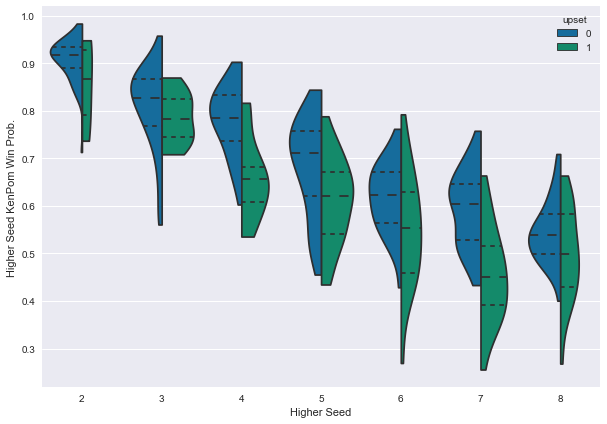

In [57]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = violinplot_kenpom(data, ax, 'win_prob_hi', 'Higher Seed KenPom Win Prob.')
plt.show()

A few things are immediately clear from this plot:

- Overall, the win probabilities slope down and to the right, since win probability drops for lower seeds.
- The green distributions (where an upset actually occurred) are lower than the blue distributions (where no upset occurred).
- There is substantial overlap between the green and blue distributions, so KenPom doesn't do a perfect job of identifying upsets. Far from it. But, if you focus on the dashed lines in the distributions (which represent the 25%, 50% and 75% quantiles of the distriubutions), you'll see that there is a noticeable distinction between the upset and non-upset distributions.

### Visualizing the Efficiency Margin Differences

The KenPom win probability is a function of the difference between the teams' efficiency margins. We can also look at those efficiency margins directly. The story isn't really that different, as we'll soon see. But, since the efficiency margins are relatively easy to understand, it may help your intuition to look at the data from this perspective.

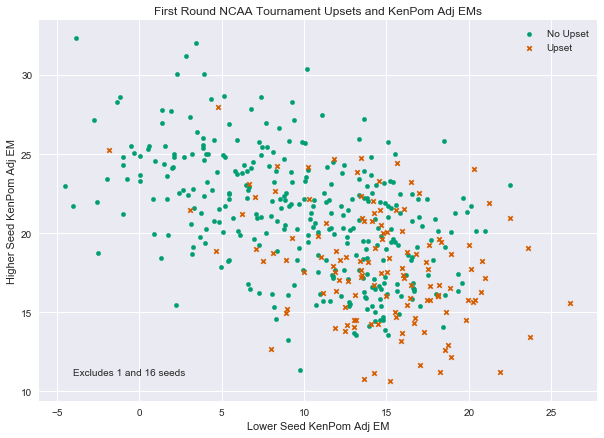

In [58]:
fig, ax = plt.subplots(figsize=(10, 7))
palette_colors = sns.color_palette()
data[data['upset'] == 0].plot(
    kind='scatter',
    x='adj_em_lo',
    y='adj_em_hi',
    label='No Upset',
    color=palette_colors[1],
    ax=ax,
)
data[data['upset'] == 1].plot(
    kind='scatter',
    x='adj_em_lo',
    y='adj_em_hi',
    label='Upset',
    marker='x',
    color=palette_colors[2],
    ax=ax,
)
ax.set_xlabel('Lower Seed KenPom Adj EM')
ax.set_ylabel('Higher Seed KenPom Adj EM')
ax.set_title('First Round NCAA Tournament Upsets and KenPom Adj EMs')
ax.text(x=-4, y=11, s='Excludes 1 and 16 seeds')
plt.show()

The upsets (marked with 'x' for each data point) are clearly skewed to the lower right relative to the non-upset dots. Upsets have tended to occurr more often when the lower seeded team has a relatively high KenPom _AdjEM_, or where the higher seeded team has a relativley low KenPom _AdjEM_. Of course, this is just another way of saying that the higher seeded team has a lower KenPom win probability.

#### Visualizing the Distribution by Seed

The overall picture makes it clear that KenPom data should be somewhat useful in predicting first round upsets. However, it's important to look at the results in more detail by seed.

Let's decompose the scatter plot above into 6 plots, one for each seed 3 through 8. We will skip the second seed games since there are so few upsets.

First, we need a function to isolate the data we need for each sub-plot.

In [59]:
def select(data, upset=None, seed_hi=None):
    """Extract data based upon higher seed and upset dummy variable."""
    if upset and seed_hi:
        return data[(data['upset'] == upset) & (data['seed_hi'] == seed_hi)]
    elif upset:
        return data[data['upset'] == upset]
    elif seed_hi:
        return data[data['seed_hi'] == seed_hi]
    else:
        raise ValueError('invalid parameters')

This function converts a seed into a `tuple` telling us which sub-plot goes with which seed.

In [60]:
def ax_map(seed):
    """Map higher seed to a sub-plot."""
    return (seed-3)%3, (seed-3)//3

This function will plot the scatter plot for one particular seed game.

In [61]:
def subplot_kenpom(data, ax, seed_hi, x, y):
    """Scatter sub-plot for a particular seed."""
    palette_colors = sns.color_palette()
    df0 = select(data, upset=0, seed_hi=seed_hi)
    df1 = select(data, upset=1, seed_hi=seed_hi)
    ax.plot(df0[x], df0[y], '.', ms=8.0, color=palette_colors[1])
    ax.plot(df1[x], df1[y], 'x', ms=8.0, mew=2, color=palette_colors[2])
    ax.set_title(f'{seed_hi}-{17-seed_hi} Games')
    return ax

Now, we can put everything together in one function which will generate the 6 sub-plots.

In [62]:
def scatterplot_kenpom(data, x='adj_em_lo', y='adj_em_hi'):
    """Create matrix of scatter sub-plots by seed."""
    fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex='col', sharey='row')
    for seed_hi in range(3, 9):
        ax = axarr[ax_map(seed_hi)]
        subplot_kenpom(data, ax, seed_hi, x, y)
    axarr[0, 0].legend(['No Upset', 'Upset'], loc='upper right')
    axarr[2, 0].set_xlabel(x)
    axarr[2, 1].set_xlabel(x)
    axarr[0, 0].set_ylabel(y)
    axarr[1, 0].set_ylabel(y)
    axarr[2, 0].set_ylabel(y)
    plt.show()

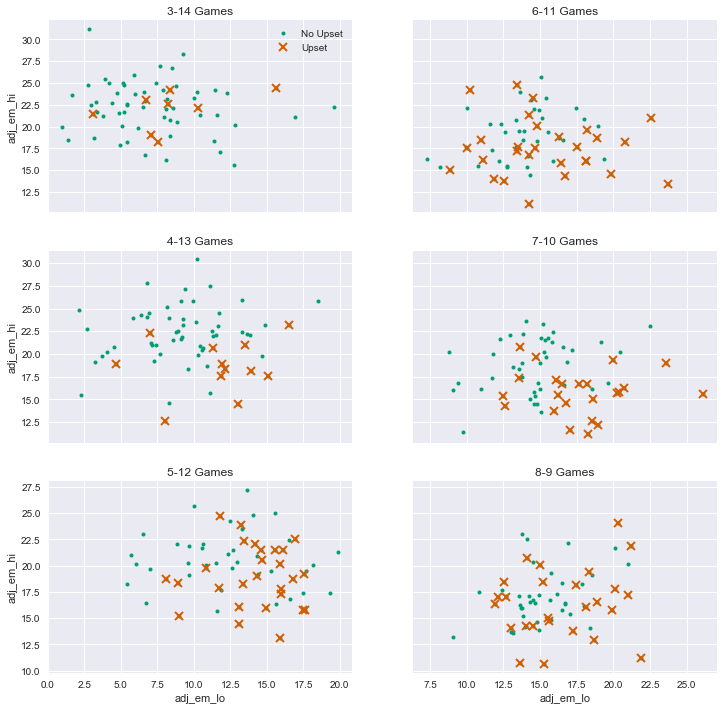

In [63]:
scatterplot_kenpom(data)

These plots show that there is a lot of noise under the surface, and that we should be cautious about relying on KenPom data in picking upsets. Although the overall patterns make sense, the historical predictive accuracy by seed is mixed. And of course, the data set is relatively small.

### Logistic Regression Plots

Let's look at the distribution by seed in another way. We can use the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) plotting functionality in the [`seaborn`](https://seaborn.pydata.org/) package to visualize the estimated upset probability as a function of the KenPom efficiency margin difference, by seed.

We won't try to explain the math behind logistic regression here. That will need to wait for future posts. The main idea is it tries to predict the value of binary variables (taking the value 0 or 1) based on the values of other variables. In our case, the binary variable is whether the upset occurred or not. The predictive variable (we hope) is the KenPom efficiency margin difference between the teams.

Using `seaborn`, we can create the plots and simultaneously have the package estimate the logistic regressions for us.

The idea is similar to the 6 scatter sub-plots we did above, except in this case we want 6 logistic regression plots.

In [64]:
def subplot_kenpom_logistic(data, ax, seed_hi, x):
    """Logistic regression sub-plot for a particular seed."""
    palette_colors = sns.color_palette()
    ax = sns.regplot(
        data=data[data['seed_hi'] == seed_hi],
        x=x,
        y='upset',
        logistic=True,
        n_boot=500,
        y_jitter=0.03,
        ax=ax,
    )
    ax.set_title(f'{seed_hi}-{17-seed_hi} Games')
    return ax

In [65]:
def regplot_kenpom(data, x='kenpom_em_diff'):
    """Create matrix of logistic regression sub-plots by seed."""
    fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex='col', sharey='row')
    for seed_hi in range(3, 9):
        ax = axarr[ax_map(seed_hi)]
        subplot_kenpom_logistic(data, ax, seed_hi, x)
    axarr[2, 0].set_xlabel(x)
    axarr[2, 1].set_xlabel(x)
    plt.show()

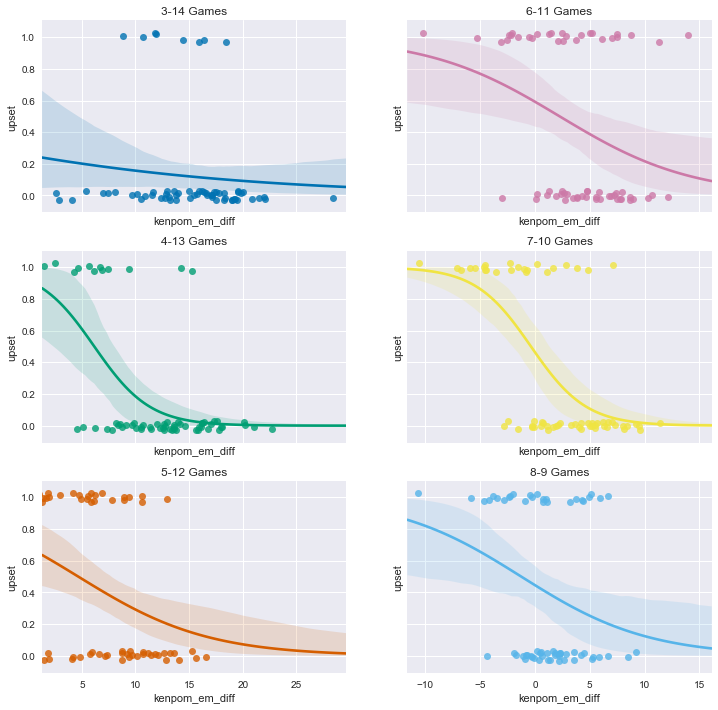

In [66]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    regplot_kenpom(data)

In these plots, the upsets are the dots with the value 'upset' equal to 1, while the 0 values are the non-upsets. The curved lines (with the surrounding shading) are the estimated probabilities of an upset, given the value of the KenPom efficiency margin difference immediately below the curve.

For example, for the 4-13 game, if the KenPom efficiency margin difference is 5, the estimated upset probability is about 60%. On the other hand, if the KenPom efficiency margin difference is 10, the estimated upset probability is only about 20% for the 4-13 game.

You can see that the model doesn't ever predict a high upset probability for the 3-14 games. The message is similar to the scatter plots we saw above. The model is more confident predicting upsets in the 4-13 games than in the 5-12 games (since the probabilty curve gets to higher values). Don't be too confident in this result, however. The data set is quite small and this could be the result of noise, or the KenPom data caveats we've discussed previously.

In any case, if you are inclined to pick upsets, this analysis shows you how to make the best possible use of the available KenPom data in making your picks.

Good luck with your brackets!